##Ví dụ 1

In [1]:
import numpy as np
from random import shuffle
N, C, d = 25000, 10, 3000
reg = .05
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

In [2]:
# calculate loss and gradient base on original formula
# reg = 1/C
def svm_loss_grad (W, X, y, reg):
    d, C = W.shape
    _, N = X.shape
    ## Loss
    loss = 0
    ## Gradient
    dW = np.zeros_like(W)
    for n in xrange(N):
        xn = X[:, n]
        score = W.T.dot(xn)
        for j in xrange(C):
            if j == y[n]:
                continue
            # 1 – (b_yn + W_yn.x_n) + (b_j + W_j.x_n)
            margin = 1 - score[y[n]] + score[j]
            if margin > 0:
                loss += margin
                dW[:, j] += xn
                dW[:, y[n]] -= xn
    loss /= N
    loss += 0.5*reg*np.sum(W * W) # regularization + 1/2C * ||w||^2
    dW /= N
    dW += reg*W # gradient off regularization 1/C*w
    return loss, dW

In [3]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, \
    batch_size = 100, num_iters = 1000, print_every = 100):
    W = Winit

    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]
        loss_history[it], dW = \
            svm_loss_grad(W, X_batch, y_batch, reg)
        W -= lr*dW
        if it % print_every == 1:
            print ('it %d/%d, loss = %f' %(it, num_iters, loss_history[it]))
    return W, loss_history

In [4]:
import numpy as np

def svm_loss_vectorized(W: np.ndarray,
                        X: np.ndarray,
                        y: np.ndarray,
                        reg: float) -> tuple[float, np.ndarray]:
    D, C = W.shape
    _, N = X.shape

    loss: float = 0.0
    dW: np.ndarray = np.zeros_like(W)

    # Compute scores
    # Z will have shape (C, N)
    Z: np.ndarray = W.T.dot(X)

    # Get the scores of the correct classes
    # correct_class_score will have shape (1, N)
    correct_class_score: np.ndarray = Z[y, np.arange(N)].reshape(1, N)

    # Compute margins
    # margins will have shape (C, N)
    margins: np.ndarray = np.maximum(0, Z - correct_class_score + 1)

    # Set margins for correct classes to 0
    margins[y, np.arange(N)] = 0

    # Compute loss
    loss = np.sum(margins) / N
    loss += 0.5 * reg * np.sum(W * W)  # Add regularization

    # Compute gradient
    # F will have shape (C, N)
    F: np.ndarray = (margins > 0).astype(int)
    F[y, np.arange(N)] = -np.sum(F, axis=0)

    # dW will have shape (D, C)
    dW = X.dot(F.T) / N + reg * W  # Add regularization gradient

    return loss, dW

In [5]:


def multiclass_svm_gd_vectorized(
    X: np.ndarray,
    y: np.ndarray,
    W_init: np.ndarray,
    reg: float,
    lr: float = 0.1,
    batch_size: int = 100,
    num_iters: int = 1000,
    print_every: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    W: np.ndarray = np.copy(W_init)  # Work on a copy to avoid modifying the original W_init
    loss_history: np.ndarray = np.zeros(num_iters)

    for it in range(num_iters):
        # Randomly pick a batch of X
        # Ensure X.shape[1] (number of samples) is not zero to avoid error
        if X.shape[1] == 0:
            print("Warning: Training data X is empty.")
            # Decide how to handle this: return early, raise error, etc.
            # For now, let's fill loss history with NaN and return current W
            loss_history[it:] = np.nan
            break
        if X.shape[1] < batch_size:
            print(
                f"Warning: batch_size ({batch_size}) is greater than the number of "
                f"available samples ({X.shape[1]}). Using all samples for this batch."
            )
            current_batch_size = X.shape[1]
        else:
            current_batch_size = batch_size

        idx: np.ndarray = np.random.choice(X.shape[1], current_batch_size, replace=False)
        X_batch: np.ndarray = X[:, idx]
        y_batch: np.ndarray = y[idx]

        # Compute loss and gradient
        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)

        # Update weights
        W -= lr * dW

        if it % print_every == 0 and print_every > 0: # Check print_every > 0 to avoid modulo by zero
            print(f"Iteration {it}/{num_iters}, loss = {loss_history[it]:.4f}")

    return W, loss_history

####Bài tập thực hành 1

--- Bắt đầu Bài tập thực hành 1 ---

Bắt đầu huấn luyện cho Bài tập thực hành 1...
Iteration 0/2000, loss = 1.9631
Iteration 200/2000, loss = 1.2408
Iteration 400/2000, loss = 1.0929
Iteration 600/2000, loss = 1.4396
Iteration 800/2000, loss = 1.4054
Iteration 1000/2000, loss = 1.5586
Iteration 1200/2000, loss = 1.3122
Iteration 1400/2000, loss = 1.0874
Iteration 1600/2000, loss = 1.4019
Iteration 1800/2000, loss = 1.5005


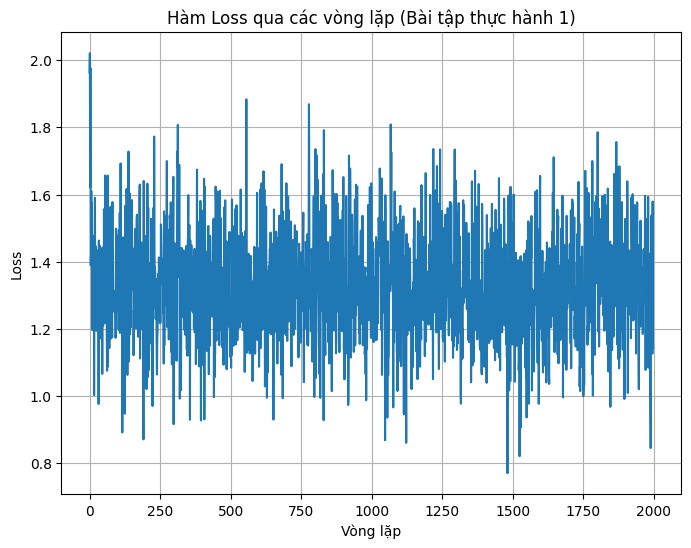

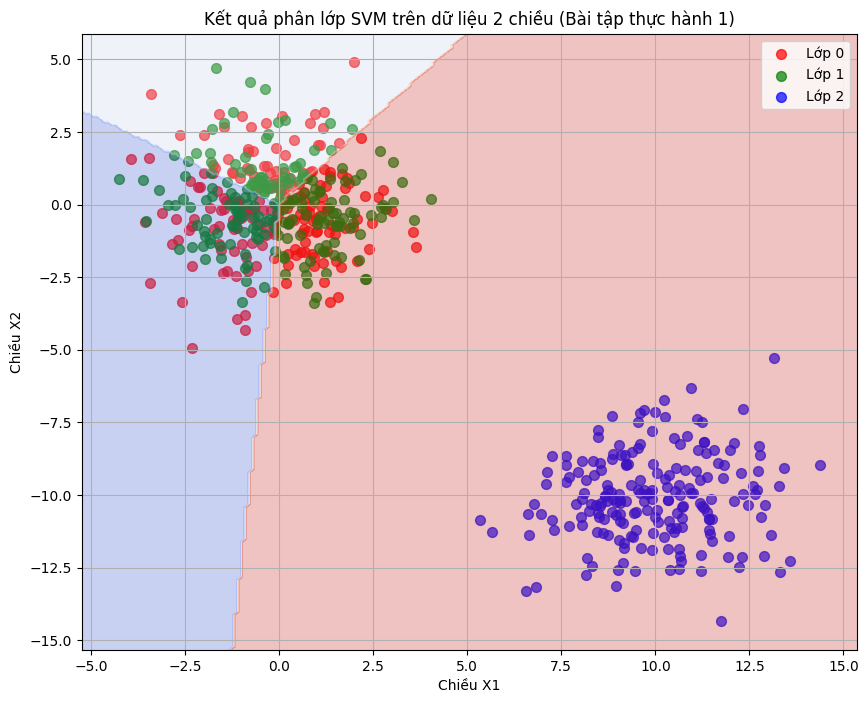

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def svm_loss_vectorized(W: np.ndarray,
                        X: np.ndarray,
                        y: np.ndarray,
                        reg: float) -> tuple[float, np.ndarray]:
    D, C = W.shape
    _, N = X.shape
    loss: float = 0.0
    dW: np.ndarray = np.zeros_like(W)

    Z: np.ndarray = W.T.dot(X) # Scores (C, N)
    correct_class_score: np.ndarray = Z[y, np.arange(N)].reshape(1, N) # (1, N)
    margins: np.ndarray = np.maximum(0, Z - correct_class_score + 1) # (C, N)
    margins[y, np.arange(N)] = 0

    loss = np.sum(margins) / N
    loss += 0.5 * reg * np.sum(W * W)

    F: np.ndarray = (margins > 0).astype(int) # (C, N)
    F[y, np.arange(N)] = -np.sum(F, axis=0)
    dW = X.dot(F.T) / N + reg * W # (D, C)

    return loss, dW

def multiclass_svm_gd_vectorized(
    X: np.ndarray,
    y: np.ndarray,
    W_init: np.ndarray,
    reg: float,
    lr: float = 0.1,
    batch_size: int = 100,
    num_iters: int = 1000,
    print_every: int = 100
) -> tuple[np.ndarray, np.ndarray]:

    W: np.ndarray = np.copy(W_init)
    loss_history: np.ndarray = np.zeros(num_iters)
    num_samples = X.shape[1]

    for it in range(num_iters):
        if num_samples == 0:
            print("Warning: Training data X is empty.")
            loss_history[it:] = np.nan
            break

        current_batch_size = batch_size
        if num_samples < batch_size:
            print(
                f"Warning: batch_size ({batch_size}) is greater than the number of "
                f"available samples ({num_samples}). Using all samples for this batch."
            )
            current_batch_size = num_samples

        idx: np.ndarray = np.random.choice(num_samples, current_batch_size, replace=False)
        X_batch: np.ndarray = X[:, idx]
        y_batch: np.ndarray = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)
        W -= lr * dW

        if print_every > 0 and it % print_every == 0:
            print(f"Iteration {it}/{num_iters}, loss = {loss_history[it]:.4f}")

    return W, loss_history

# --- Bài tập thực hành 1: Tạo dữ liệu 2 chiều và huấn luyện ---

# Tạo dữ liệu 2 chiều, 3 lớp, mỗi lớp 200 mẫu, phân bố chuẩn
N_class = 200  # Số mẫu mỗi loại
D = 2          # Số chiều
C = 3          # Số lớp

X_practice1 = np.zeros((D, N_class * C))
y_practice1 = np.zeros(N_class * C, dtype='uint8')

for j in range(C):
    ix = range(N_class * j, N_class * (j + 1))
    # Tạo các tâm (center) cho mỗi lớp để chúng có thể phân biệt được
    center_x = 5 * j if j % 2 == 0 else -5 * (j-1) # Điều chỉnh tâm để dễ hình dung
    center_y = 5 * (j-1) if j % 2 != 0 else -5 * j
    X_practice1[0, ix] = np.random.randn(N_class) * 1.5 + center_x # Phân bố chuẩn
    X_practice1[1, ix] = np.random.randn(N_class) * 1.5 + center_y # Phân bố chuẩn
    y_practice1[ix] = j

# Khởi tạo trọng số W
W_init_practice1 = np.random.randn(D, C) * 0.01
reg_practice1 = 0.001
lr_practice1 = 0.1
num_iters_practice1 = 2000
batch_size_practice1 = 50 # Giảm batch size vì tập dữ liệu nhỏ hơn
print_every_practice1 = 200

# Huấn luyện mô hình
print("\nBắt đầu huấn luyện cho Bài tập thực hành 1...")
W_trained_practice1, loss_history_practice1 = multiclass_svm_gd_vectorized(
    X_practice1, y_practice1, W_init_practice1, reg_practice1,
    lr=lr_practice1, batch_size=batch_size_practice1,
    num_iters=num_iters_practice1, print_every=print_every_practice1
)

# Vẽ đồ thị hàm Loss
plt.figure(figsize=(8, 6))
plt.plot(loss_history_practice1)
plt.title('Hàm Loss qua các vòng lặp (Bài tập thực hành 1)')
plt.xlabel('Vòng lặp')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Hiển thị trực quan các điểm mẫu trên mặt phẳng
plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b']
for j in range(C):
    ix = np.where(y_practice1 == j)
    plt.scatter(X_practice1[0, ix], X_practice1[1, ix], c=colors[j], label=f'Lớp {j}', s=50, alpha=0.7)

# Tạo lưới để vẽ đường biên quyết định (decision boundary)
x_min, x_max = X_practice1[0, :].min() - 1, X_practice1[0, :].max() + 1
y_min, y_max = X_practice1[1, :].min() - 1, X_practice1[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Dự đoán trên lưới
Z = W_trained_practice1.T.dot(np.vstack((xx.ravel(), yy.ravel()))) # Scores
Z_labels = np.argmax(Z, axis=0) # Predicted labels
Z_labels = Z_labels.reshape(xx.shape)

plt.contourf(xx, yy, Z_labels, alpha=0.3, cmap=plt.cm.coolwarm)
plt.title('Kết quả phân lớp SVM trên dữ liệu 2 chiều (Bài tập thực hành 1)')
plt.xlabel('Chiều X1')
plt.ylabel('Chiều X2')
plt.legend()
plt.grid(True)
plt.show()




####Bài tập tự thực hành 2


Độ chính xác (Accuracy) trên tập dữ liệu huấn luyện: 54.00%

Ma trận nhầm lẫn (Confusion Matrix):
[[ 71  57  72]
 [ 67  53  80]
 [  0   0 200]]


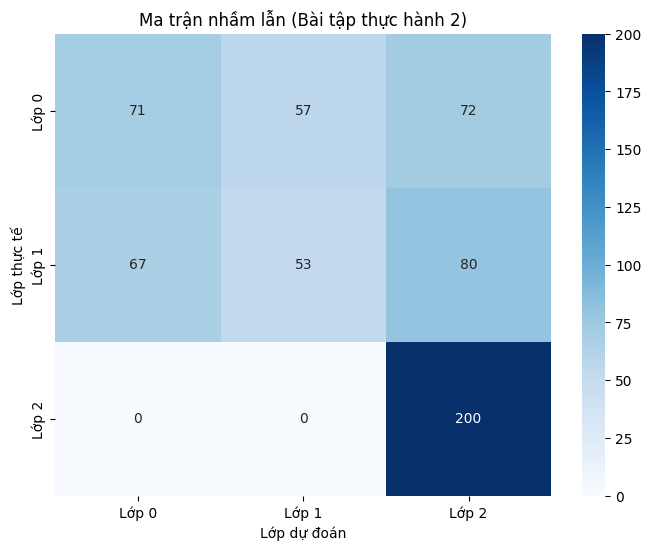

In [7]:
# Sử dụng bộ trọng số W đã tính được (W_trained_practice1)
# và dự đoán các phân lớp y ứng với dữ liệu X (X_practice1, y_practice1)

# Dự đoán trên chính tập dữ liệu huấn luyện
scores_practice2 = W_trained_practice1.T.dot(X_practice1)
y_pred_practice2 = np.argmax(scores_practice2, axis=0)

# Đưa ra độ chính xác Accuracy
accuracy = accuracy_score(y_practice1, y_pred_practice2)
print(f"\nĐộ chính xác (Accuracy) trên tập dữ liệu huấn luyện: {accuracy * 100:.2f}%")

# Đưa ra ma trận nhầm lẫn Confusion Matrix
conf_matrix = confusion_matrix(y_practice1, y_pred_practice2)
print("\nMa trận nhầm lẫn (Confusion Matrix):")
print(conf_matrix)

# Hiển thị ma trận nhầm lẫn một cách trực quan hơn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Lớp {i}" for i in range(C)],
            yticklabels=[f"Lớp {i}" for i in range(C)])
plt.title('Ma trận nhầm lẫn (Bài tập thực hành 2)')
plt.xlabel('Lớp dự đoán')
plt.ylabel('Lớp thực tế')
plt.show()


####Bài tập thực hành 3

--- Bắt đầu Bài tập thực hành 3: Phân loại chữ số viết tay MNIST ---
Đang tải dữ liệu MNIST...
Tải dữ liệu MNIST hoàn tất.
Kích thước tập huấn luyện X: (784, 60000)
Kích thước tập huấn luyện y: (60000,)
Kích thước tập kiểm tra X: (784, 10000)
Kích thước tập kiểm tra y: (10000,)

Bắt đầu huấn luyện mô hình SVM cho MNIST...
Iteration 0/2000, loss = 9.0175
Iteration 100/2000, loss = 0.7317
Iteration 200/2000, loss = 0.5060
Iteration 300/2000, loss = 0.4769
Iteration 400/2000, loss = 0.6452
Iteration 500/2000, loss = 0.2270
Iteration 600/2000, loss = 0.4091
Iteration 700/2000, loss = 0.3670
Iteration 800/2000, loss = 0.4027
Iteration 900/2000, loss = 0.3682
Iteration 1000/2000, loss = 0.2700
Iteration 1100/2000, loss = 0.2935
Iteration 1200/2000, loss = 0.3235
Iteration 1300/2000, loss = 0.3250
Iteration 1400/2000, loss = 0.3906
Iteration 1500/2000, loss = 0.3052
Iteration 1600/2000, loss = 0.2567
Iteration 1700/2000, loss = 0.3379
Iteration 1800/2000, loss = 0.4250
Iteration 1900/2000, lo

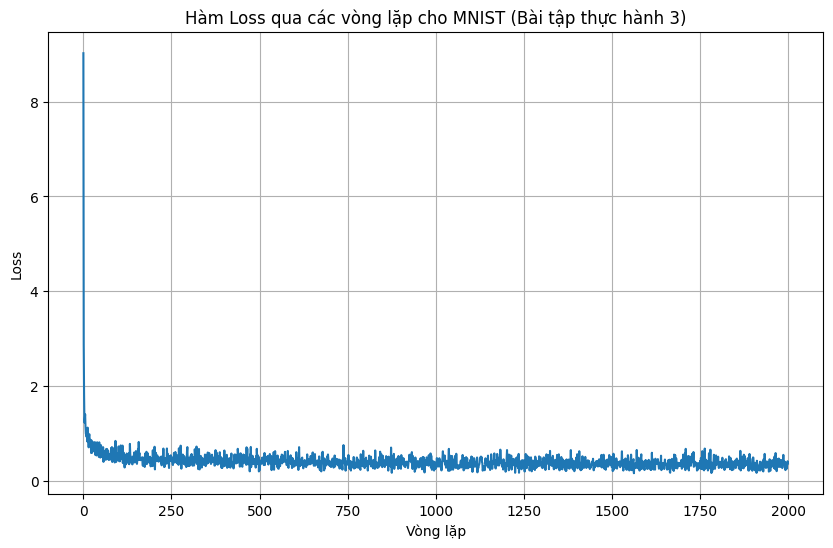


Đánh giá mô hình trên tập kiểm tra...
Độ chính xác (Accuracy) trên tập kiểm tra MNIST: 91.70%

Ma trận nhầm lẫn (Confusion Matrix) trên tập kiểm tra MNIST:
[[ 951    1    3    1    4   13    7    0    4    2]
 [   0 1095    5    4    0    6    2    2    8    3]
 [  10    9  884   18   19    5   12   14   23    5]
 [   5    5   28  898    2   37    3   14   20    8]
 [   0    3    3    1  907    1    9    4    6   41]
 [   5    3    3   34    7  794   16    6   26    8]
 [  10    1    6    0   13   15  933    0    4    0]
 [   3    8   14    2    6    2    0  976    4   27]
 [   7   22    9   30    5   34    9    8  839   12]
 [   8    7    3   20   28    7    1   20    7  893]]


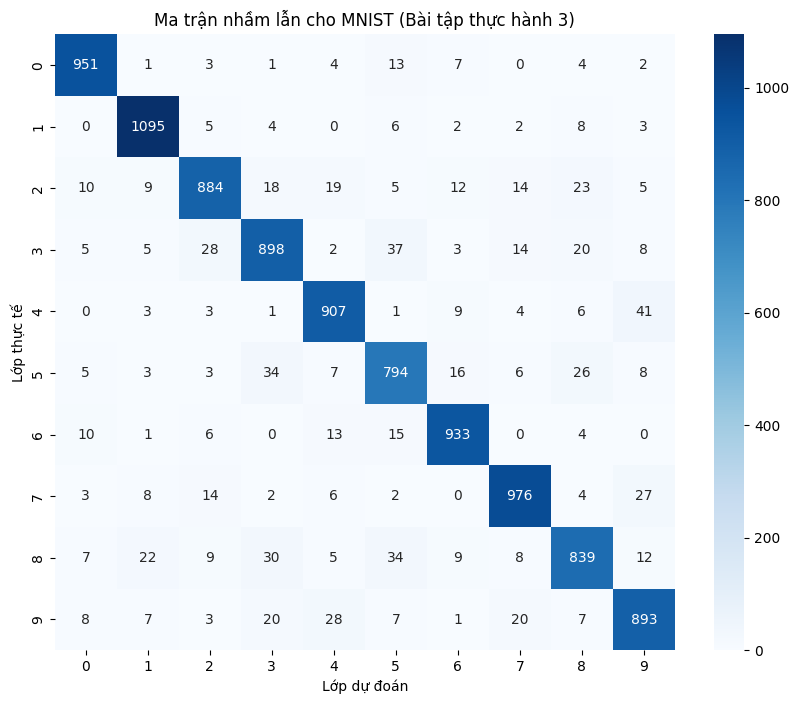

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import time

def svm_loss_vectorized(W: np.ndarray,
                        X: np.ndarray,
                        y: np.ndarray,
                        reg: float) -> tuple[float, np.ndarray]:
    D, C = W.shape
    _, N = X.shape
    loss: float = 0.0
    dW: np.ndarray = np.zeros_like(W)

    if N == 0: # Handle empty batch
        return 0.0, dW

    Z: np.ndarray = W.T.dot(X) # Scores (C, N)
    correct_class_score: np.ndarray = Z[y, np.arange(N)].reshape(1, N) # (1, N)
    margins: np.ndarray = np.maximum(0, Z - correct_class_score + 1) # (C, N)
    margins[y, np.arange(N)] = 0

    loss = np.sum(margins) / N
    loss += 0.5 * reg * np.sum(W * W)

    F: np.ndarray = (margins > 0).astype(int) # (C, N)
    F[y, np.arange(N)] = -np.sum(F, axis=0)
    dW = X.dot(F.T) / N + reg * W # (D, C)

    return loss, dW

def multiclass_svm_gd_vectorized(
    X: np.ndarray,
    y: np.ndarray,
    W_init: np.ndarray,
    reg: float,
    lr: float = 0.1,
    batch_size: int = 200, # MNIST is larger, can use larger batch
    num_iters: int = 1500, # Might need more iterations for MNIST
    print_every: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs multiclass SVM training using vectorized Gradient Descent.
    """
    W: np.ndarray = np.copy(W_init)
    loss_history: np.ndarray = np.zeros(num_iters)
    num_samples = X.shape[1]

    for it in range(num_iters):
        if num_samples == 0:
            print("Warning: Training data X is empty.")
            loss_history[it:] = np.nan
            break

        current_batch_size = batch_size
        if num_samples < batch_size:
            print(
                f"Warning: batch_size ({batch_size}) is greater than the number of "
                f"available samples ({num_samples}). Using all samples for this batch."
            )
            current_batch_size = num_samples

        if current_batch_size == 0: # Avoid error if X was non-empty but became effectively empty
            loss_history[it:] = np.nan
            break


        idx: np.ndarray = np.random.choice(num_samples, current_batch_size, replace=False)
        X_batch: np.ndarray = X[:, idx]
        y_batch: np.ndarray = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)
        W -= lr * dW

        if print_every > 0 and it % print_every == 0:
            print(f"Iteration {it}/{num_iters}, loss = {loss_history[it]:.4f}")

    return W, loss_history

# --- Bài tập thực hành 3: Áp dụng cho MNIST ---

# 1. Tải dữ liệu MNIST
print("Đang tải dữ liệu MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist, y_mnist = mnist["data"], mnist["target"]
print("Tải dữ liệu MNIST hoàn tất.")

# Chuyển y_mnist sang kiểu integer
y_mnist = y_mnist.astype(np.uint8)

# 2. Chuẩn bị dữ liệu
# Chia thành tập huấn luyện và tập kiểm tra (ví dụ: 60000 train, 10000 test)
X_train, X_test, y_train, y_test = train_test_split(
    X_mnist, y_mnist, test_size=10000, train_size=60000, random_state=42, stratify=y_mnist
)

# Chuẩn hóa dữ liệu (Standard Scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển vị X để có dạng (D, N) như hàm SVM mong đợi
# D: số chiều (784), N: số mẫu
X_train = X_train.T
X_test = X_test.T

print(f"Kích thước tập huấn luyện X: {X_train.shape}") # (784, 60000)
print(f"Kích thước tập huấn luyện y: {y_train.shape}") # (60000,)
print(f"Kích thước tập kiểm tra X: {X_test.shape}")   # (784, 10000)
print(f"Kích thước tập kiểm tra y: {y_test.shape}")   # (10000,)

# 3. Khởi tạo tham số và Huấn luyện
D_mnist = X_train.shape[0]  # Số chiều (784)
C_mnist = len(np.unique(y_train))  # Số lớp (10, cho các chữ số 0-9)

# Khởi tạo trọng số W
W_init_mnist = np.random.randn(D_mnist, C_mnist) * 0.001 # Khởi tạo nhỏ

# Tham số huấn luyện (có thể cần điều chỉnh để có kết quả tốt nhất)
reg_mnist = 0.001          # Hệ số điều chuẩn (regularization)
lr_mnist = 0.01            # Tốc độ học (learning rate)
num_iters_mnist = 2000     # Số vòng lặp
batch_size_mnist = 256     # Kích thước batch
print_every_mnist = 100

print("\nBắt đầu huấn luyện mô hình SVM cho MNIST...")
start_time = time.time()
W_trained_mnist, loss_history_mnist = multiclass_svm_gd_vectorized(
    X_train, y_train, W_init_mnist, reg_mnist,
    lr=lr_mnist, batch_size=batch_size_mnist,
    num_iters=num_iters_mnist, print_every=print_every_mnist
)
end_time = time.time()
print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây.")

# Vẽ đồ thị hàm Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history_mnist)
plt.title('Hàm Loss qua các vòng lặp cho MNIST (Bài tập thực hành 3)')
plt.xlabel('Vòng lặp')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 4. Đánh giá mô hình trên tập kiểm tra
print("\nĐánh giá mô hình trên tập kiểm tra...")
# Dự đoán trên tập kiểm tra
scores_mnist_test = W_trained_mnist.T.dot(X_test) # (C, N_test)
y_pred_mnist_test = np.argmax(scores_mnist_test, axis=0) # (N_test,)

# Độ chính xác (Accuracy)
accuracy_mnist = accuracy_score(y_test, y_pred_mnist_test)
print(f"Độ chính xác (Accuracy) trên tập kiểm tra MNIST: {accuracy_mnist * 100:.2f}%")

# Ma trận nhầm lẫn (Confusion Matrix)
conf_matrix_mnist = confusion_matrix(y_test, y_pred_mnist_test)
print("\nMa trận nhầm lẫn (Confusion Matrix) trên tập kiểm tra MNIST:")
print(conf_matrix_mnist)

# Hiển thị ma trận nhầm lẫn một cách trực quan hơn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mnist, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(C_mnist), yticklabels=range(C_mnist))
plt.title('Ma trận nhầm lẫn cho MNIST (Bài tập thực hành 3)')
plt.xlabel('Lớp dự đoán')
plt.ylabel('Lớp thực tế')
plt.show()


## Ví dụ 2

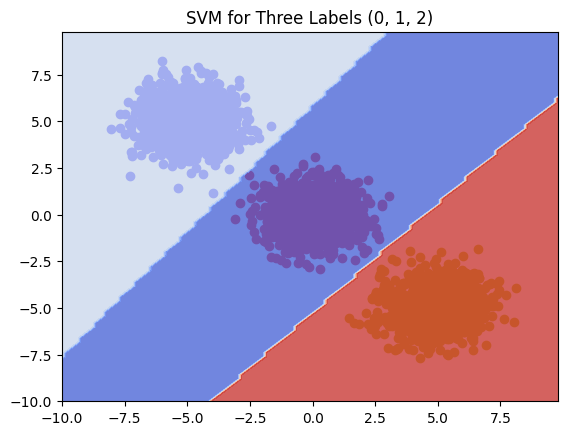

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
N = 1000 # Number of samples
# Create synthetic dataset
X1 = np.random.normal(loc=0, scale=1, size=(N, 2))
Y1 = 0 * np.ones(shape=(1000,)) # LABEL = 0
X2 = np.random.normal(loc=[-5, 5], scale=1, size=(N, 2))
Y2 = 1 * np.ones(shape=(1000,)) # LABEL = 1
X3 = np.random.normal(loc=[5, -5], scale=1, size=(N, 2))
Y3 = 2 * np.ones(shape=(1000,)) # LABEL = 2
# Create stacked dataset
X = np.vstack((X1, X2, X3))
Y = np.hstack((Y1, Y2, Y3))
# TRAIN SVM LEARNING ALGORITHM
clf = SVC(kernel='linear')
clf = clf.fit(X, Y)
# create decision boundary plot
xx, yy = np.meshgrid(
np.arange(-10, 10, 0.2),
np.arange(-10, 10, 0.2))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# PLOT EVERYTHING
plt.scatter(X1[:,0], X1[:,1], color='r')
plt.scatter(X2[:,0], X2[:,1], color='b')
plt.scatter(X3[:,0], X3[:,1], color='y')
plt.contourf(xx,yy,Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.title("SVM for Three Labels (0, 1, 2)")
plt.show()

#### Bài tập tự thực hành 4

Đang tải dữ liệu MNIST...
Tải dữ liệu MNIST hoàn tất.
Kích thước tập huấn luyện X: (1000, 784)
Kích thước tập huấn luyện y: (1000,)
Kích thước tập kiểm tra X: (500, 784)
Kích thước tập kiểm tra y: (500,)

Bắt đầu huấn luyện mô hình SVM...
Huấn luyện hoàn tất trong 0.16 giây.

Bắt đầu dự đoán trên 500 ảnh kiểm tra...
Một vài dự đoán đầu tiên (Thực tế -> Dự đoán):
6 -> 6
0 -> 0
3 -> 3
8 -> 8
0 -> 0
7 -> 7
5 -> 5
2 -> 2
1 -> 1
9 -> 9

Độ chính xác trên 500 ảnh kiểm tra: 87.60%

Ma trận nhầm lẫn:
[[45  0  0  0  0  2  2  0  0  0]
 [ 0 55  1  0  0  0  0  0  0  0]
 [ 0  2 40  2  3  0  1  0  2  0]
 [ 1  1  1 41  1  3  0  0  3  0]
 [ 0  0  1  0 47  0  1  0  0  0]
 [ 0  0  1  3  1 37  0  0  3  0]
 [ 0  0  3  0  0  3 42  0  1  0]
 [ 0  0  0  1  0  0  0 51  0  0]
 [ 0  5  1  0  1  1  1  0 40  0]
 [ 0  0  0  0  7  1  0  2  0 40]]


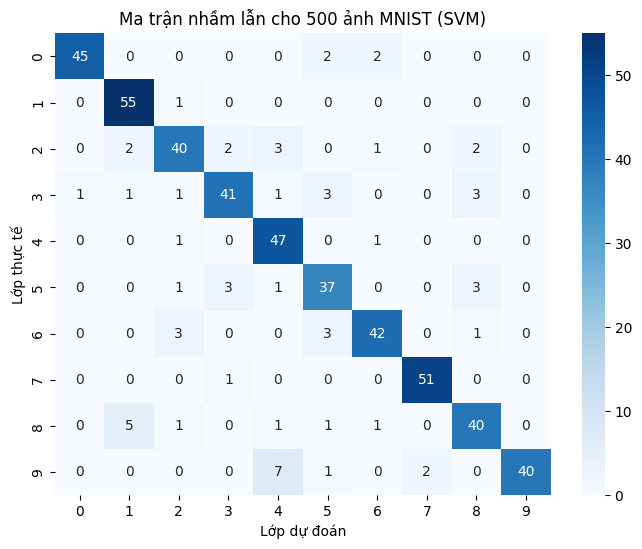

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import time


# 1. Tải dữ liệu MNIST
print("Đang tải dữ liệu MNIST...")
# Sử dụng parser='auto' để tránh các vấn đề về phiên bản trong tương lai
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_mnist, y_mnist_str = mnist["data"], mnist["target"]
print("Tải dữ liệu MNIST hoàn tất.")

# Chuyển nhãn y_mnist sang kiểu số nguyên
y_mnist = y_mnist_str.astype(np.uint8)

# 2. Chuẩn bị dữ liệu
# Chia dữ liệu để lấy 1000 mẫu cho huấn luyện và 500 mẫu cho kiểm tra (từ phần còn lại)
# Đảm bảo không có sự chồng chéo giữa tập huấn luyện và tập kiểm tra dùng cho dự đoán.

# Chia lần 1: tách 1500 mẫu đầu tiên (1000 train + 500 test) và phần còn lại
X_subset, _, y_subset, _ = train_test_split(
    X_mnist, y_mnist, train_size=1500, random_state=42, stratify=y_mnist
)

# Chia lần 2: tách 1500 mẫu này thành 1000 cho huấn luyện và 500 cho kiểm tra
X_train_1000, X_test_500, y_train_1000, y_test_500 = train_test_split(
    X_subset, y_subset, train_size=1000, test_size=500, random_state=42, stratify=y_subset
)

print(f"Kích thước tập huấn luyện X: {X_train_1000.shape}") # (1000, 784)
print(f"Kích thước tập huấn luyện y: {y_train_1000.shape}") # (1000,)
print(f"Kích thước tập kiểm tra X: {X_test_500.shape}")   # (500, 784)
print(f"Kích thước tập kiểm tra y: {y_test_500.shape}")   # (500,)

# Chuẩn hóa dữ liệu pixel (Scaling)
# Giống như trong ví dụ gốc có StandardScaler, ta sẽ dùng nó ở đây.
# Hoặc có thể chia cho 255.0 nếu pixel values trong khoảng 0-255.
# fetch_openml thường trả về dữ liệu trong khoảng 0-255.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_1000)
X_test_scaled = scaler.transform(X_test_500)

# 3. Huấn luyện thuật toán SVM (TRAIN SVM LEARNING ALGORITHM)
print("\nBắt đầu huấn luyện mô hình SVM...")
start_time = time.time()
# Sử dụng SVC với kernel tuyến tính như trong ví dụ
clf = SVC(kernel='linear')
clf.fit(X_train_scaled, y_train_1000) # clf = clf.fit(X, Y) trong ví dụ
end_time = time.time()
print(f"Huấn luyện hoàn tất trong {end_time - start_time:.2f} giây.")

# 4. Thực hiện dự đoán phân loại cho 500 ảnh khác
print("\nBắt đầu dự đoán trên 500 ảnh kiểm tra...")
y_pred_500 = clf.predict(X_test_scaled)

# In ra một vài dự đoán đầu tiên để xem
print("Một vài dự đoán đầu tiên (Thực tế -> Dự đoán):")
for i in range(min(10, len(y_test_500))): # In tối đa 10 dự đoán
    print(f"{y_test_500[i]} -> {y_pred_500[i]}")

# 5. Đánh giá kết quả (Tùy chọn nhưng hữu ích)
accuracy = accuracy_score(y_test_500, y_pred_500)
print(f"\nĐộ chính xác trên 500 ảnh kiểm tra: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test_500, y_pred_500)
print("\nMa trận nhầm lẫn:")
print(conf_matrix)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_mnist), yticklabels=np.unique(y_mnist))
plt.title('Ma trận nhầm lẫn cho 500 ảnh MNIST (SVM)')
plt.xlabel('Lớp dự đoán')
plt.ylabel('Lớp thực tế')
plt.show()
